<a href="https://colab.research.google.com/github/chitransh1998/portfolio/blob/main/Life_Expectancy_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Life Expectancy Prediction using Linear Regression

## Dataset
In this dataset we predict Life expectancy of different countries. We will explore how immunization factors, mortality factors, economic factors, social factors and other health related factors affect Life expectancy of a country.

There are two data files: "LifeExpectancy_training_modified.csv" and "LifeExpectancy_test_modified.csv"<br/>
Both files have the following fields, except Life_expectancy which is not available in "LifeExpectancy_test_modified.csv"

Features :
- Year : from 2002 to 2015
- Status : Developed or Developing status
- Adult_Mortality : Adult Mortality Rates of both sexes (probability of dying between 15 and 60 years per 1000 population)
- Alcohol : Alcohol, recorded per capita (15+) consumption (in litres of pure alcohol)
- percentage_expenditure : Expenditure on health as a percentage of Gross Domestic Product per capita(%)
- BMI: Average Body Mass Index of entire population
- Total_expenditure: General government expenditure on health as a percentage of total government expenditure (%)
- Diphtheria: Diphtheria tetanus toxoid and pertussis (DTP3) immunization coverage among 1-year-olds (%)
- HIV_AIDS: Deaths per 1000 live births HIV/AIDS (0-4 years)
- GDP: Gross Domestic Product per capita (in USD)
- Population
- Income_composition_of_resources: Human Development Index in terms of income composition of resources (index ranging from 0 to 1)
- Schooling: Number of years of Schooling(years)
- Health_Index: Health index

Target:
- Life_expectancy: Life Expectancy in age


Training dataset, "LifeExpectancy_training_modified.csv", contains 1064 rows and 15 columns. This is the training set containing both of the features and the target.<br/>
Test dataset, "LifeExpectancy_test_modified.csv", contains 458 rows and 14 columns. This is the test set which only contains the features.<br/>

Our goal is to predict Life expectancy based on the features.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, r2_score, mean_squared_error
from itertools import chain, combinations

Load the training data "LifeExpectancy_training_modified.csv" in Colab and View the first 5 lines

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving LifeExpectancy_training_modified.csv to LifeExpectancy_training_modified.csv


In [ ]:
# Load the training data
import io
df = pd.read_csv(io.BytesIO(uploaded['LifeExpectancy_training_modified.csv']))

In [ ]:
# Show the first 5 lines
df.head()

,Year,Status,Adult_Mortality,Alcohol,percentage_expenditure,BMI,Total_expenditure,Diphtheria,HIV_AIDS,GDP,Population,Income_composition_of_resources,Schooling,Health_Index,Life_expectancy
0,2011,Developing,93,1.57,835.062683,64.0,7.12,81,0.1,8734.96530,4588368.0,0.758,13.2,0.475880,75.0
1,2014,Developing,152,6.41,789.077295,32.4,4.12,99,0.1,5941.84710,68416772.0,0.737,13.6,0.203275,74.6
2,2013,Developed,68,11.82,90.585012,56.6,11.14,95,0.1,554.71532,8479375.0,0.887,15.7,0.913847,81.1
3,2014,Developed,135,0.01,1.576409,59.9,5.57,94,0.1,12.27733,1998979.0,0.797,14.7,0.275401,74.8
4,2002,Developing,192,5.93,27.638103,2.2,3.70,96,0.7,296.54617,6473164.0,0.657,11.5,0.400974,71.4


## Data Exploration
We can plot a histogram of the dataframe for the features except "Status" to understand their distributions. <br/>

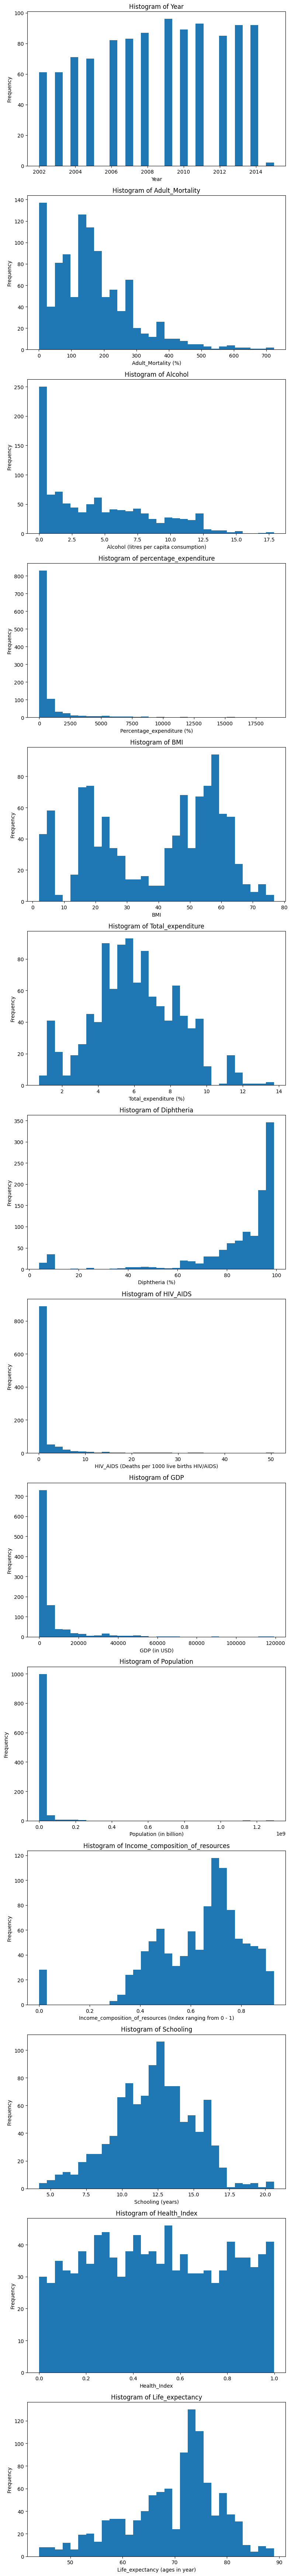

In [ ]:
###CODE TO OBTAIN AND DISPLAY HISTOGRAMS ###
ncolumns = df.select_dtypes(include=['number']).columns.tolist()
ncolumns = [col for col in ncolumns if col != 'Status']

# Dictionary to map column index to its respective label
labels = {
    0: 'Year',
    1: 'Adult_Mortality (%)',
    2: 'Alcohol (litres per capita consumption)',
    3: 'Percentage_expenditure (%)',
    4: 'BMI',
    5: 'Total_expenditure (%)',
    6: 'Diphtheria (%)',
    7: 'HIV_AIDS (Deaths per 1000 live births HIV/AIDS)',
    8: 'GDP (in USD)',
    9: 'Population (in billion)',
    10: 'Income_composition_of_resources (Index ranging from 0 - 1)',
    11: 'Schooling (years)',
    12: 'Health_Index',
    13: 'Life_expectancy (ages in year)'
}

fig, axes = plt.subplots(nrows=len(ncolumns), ncols=1, figsize=(8, 5*len(ncolumns)))

# Using for loops to generate the histograms
for i, col in enumerate(ncolumns):
    axes[i].hist(df[col], bins=30)
    axes[i].set_ylabel('Frequency')
    axes[i].set_title(f'Histogram of {col}')
    axes[i].set_xlabel(labels.get(i, ''))

plt.tight_layout()
plt.show()


**Inference from Histograms** <br/>
*    **`Year`**: Data has been collected for all years from 2002 to 2014, but data collection for 2015 is low. The distribution is almost uniform (with the exception of data collection in earlier years and 2015)
*    **`Adult_Mortality`**: It is a right-skewed distribution with two peaks. Among all the data that has been collected, the most common `adult_mortality` rate is the 0-25 and 125-150 Death in a population of 1000.
*    **`Alcohol`**: It is also a right-skewed histogram with a long tail. This indicates that the majority of people living in the countries that are covered in the dataset are not heavy alcohol consumer. Most people consumed about 0-2.5 liters of alcohol annually.
*    **`Percentage_expenditure`**: It is an decreasing exponential distribution. This means that for most countries in the dataset, health takes up to 0-1250% of GDP per capita. Health is very costly in most countries for many people.
*    **`BMI`**: It is a multimodel distribution with more than 1 peaks. That means that `BMI`s vary a lot in countries across different years.
*    **`Total_expenditure`**: It is approximatly a normal distribution with center at ~5% - 7%. The means that most countries in this dataset invest approximately 5% to 7% of their total government_expenditure on health.
*    **`Diphtheria`**: It is a highly left-skewed distribution with a long tail. The majority of samples(93% - 100%) in ths dataset has diphtheria coverages among 1 years-old.
*    **`HIV_AIDS`**: Both the mean and median of this histogram is at 0-3. It is an exponential distribution with a long tail. The majority of countries in this dataset has less than 3 Deaths per 1000 live births HIV/AIDS.
*    **`GDP`**: The average values of this histogram is around the 500 value. The majority of countries in this dataset has `GDP` ~500 USD per capita. This is a high number.
*    **`Population`**: The majority of countries in this dataset has 100000000 population. This gives us a sense that countries with large populations were targetted for data collection.
*    **`income_composition_of_resources`**: It is a left-skewed distribution with a peaks around 0.7. That means most countries in this dataset tends to have high (>0.5) Human Development Index.
*    **`Schooling`**: It is a normal distribution centered around 12.5 years. Most commonly countries in this dataset has a schooling curriculum of 12.5 years.
*    **`Health_Index`**: It is a uniform distribution. Countries in this dataset have very diverse `Health_Index`.
*    **`Life_expectancy`**: It is roughly a normal distribution but slightly left-skewed. Most people in this dateset has a `life_expectancy` ~70-80 years.




Correlation matrix to get an understanding of the correlation between life_expectancy and the other features.<br/>

<ipython-input-6-9f9cd66211fe>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


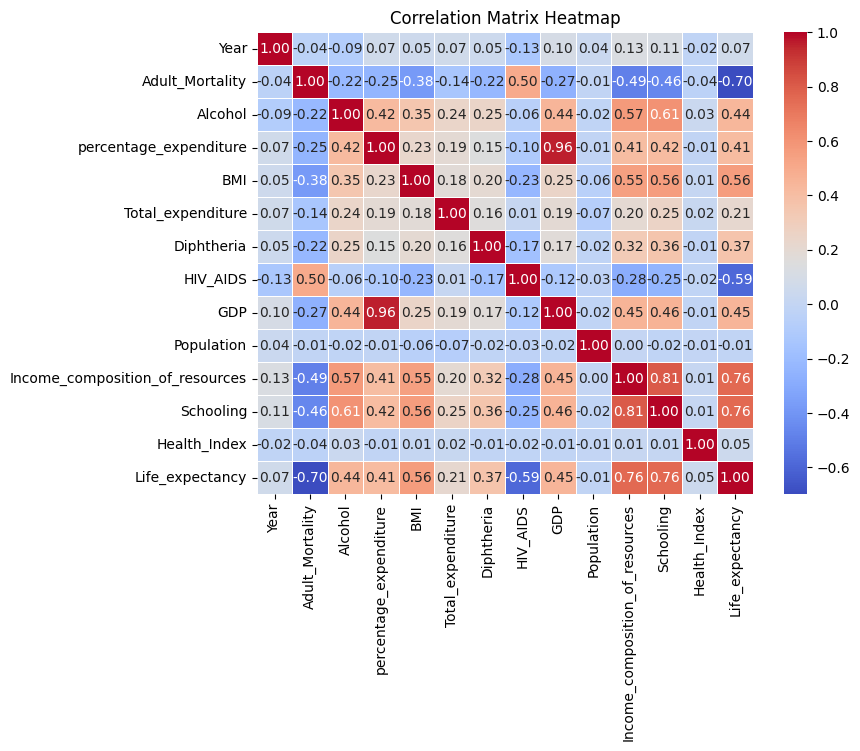

In [ ]:
###CODE TO OBTAIN CORRELATION MATRIX ###
corr_matrix = df.corr()

### CODE TO CREATE HEATMAP OF CORRELATION MATRIX
plt.figure(figsize = (8,6))
sns.heatmap(corr_matrix, annot = True, cmap = 'coolwarm', fmt = ".2f", linewidth = 0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

**Inference about variables from the Correlation Matrix**:<br/>


If we have to choose one predictor for a simple linear regression model with Life_expectancy as the outcome, we will choose `Income_composition_of_resources` because it is most correlated with `Life_expectancy` according to our correlation matrix. corr(Income_composition_of_resources, Life_expectancy) = 0.756515.   
Schooling can be the second good choice because it also has a high correlation of 0.755132. Note that in the heatmap above, the correlations of the two features each with `life_expectancy` appear to be both 0.76. This is caused by rounding.  
Qualitatively speaking, it is better to choose `Income_composition_of_resources` as the data can be collected and interpreted easily.
<br/><br/>

**Variables not making sense** <br/>

**`year`**: <br/>Data has been collected for all years from 2002 - 2014 however data collection for 2015 is very low. This is likely because the data set was potentially extracted during 2015.

**`Health_Index`**: <br/>
The feature `Health_Index` is not fully defined in the prompt. We do not know what is being calculated in this Health_Index.

**Missing variables**: <br/>
In order to calculate the life expectancy of a country, the current set of variables may not be sufficient. We believe that other variables such as Drug_usage, Mental_health, air_pollution_rate and more can be added.


### Standardization of features

Feature standardization makes the values of each feature in the data have zero-mean and unit-variance. This method is widely used for normalization in many machine learning algorithms. The general method of calculation is to determine the distribution mean and standard deviation for each feature. Next we subtract the mean from each feature. Then we divide the values of each feature by its standard deviation.

$x'$ = ($x$ - $\bar{x}$)/$\sigma$

where $x$ is the original feature vector,
$\bar{x}$ is the mean of the feature vector and
$\sigma$ is its standard deviation.

This is also called Z-score Normalization.

Z-score Normalization on the features (except "Year" and "Status") in both training and test set.

In [ ]:
# Load the test set "LifeExpectancy_test_modified.csv"

from google.colab import files
uploaded_2 = files.upload()

Saving LifeExpectancy_test_modified.csv to LifeExpectancy_test_modified.csv


In [ ]:
# Read the testing set
df_2 = pd.read_csv(io.BytesIO(uploaded_2['LifeExpectancy_test_modified.csv']))

In [ ]:
from sklearn.preprocessing import StandardScaler
###CODE TO PERFORM Z-score Normalization ###

# Drop "Year" and "Status" in both training and test set and extract other columns
features_normal_train = df.drop(["Year", "Status", "Life_expectancy"], axis = 1).columns
features_normal_test = df_2.drop(["Year", "Status"], axis = 1).columns

# Initialize the standard scaler, specifying that we need both mean and std
scaler = StandardScaler(with_mean = True, with_std = True)

# z-score normalization on the training and test set
scaled_train = scaler.fit_transform(df[features_normal_train])
scaled_test = scaler.fit_transform(df_2[features_normal_test])

# Convert to dataframe for both scaled training and testing dataset
scaled_train_df = pd.DataFrame(scaled_train, columns=features_normal_train)
scaled_test_df = pd.DataFrame(scaled_test, columns=features_normal_test)

In [ ]:
scaled_train_df

,Adult_Mortality,Alcohol,percentage_expenditure,BMI,Total_expenditure,Diphtheria,HIV_AIDS,GDP,Population,Income_composition_of_resources,Schooling,Health_Index
0,-0.595190,-0.726456,0.048715,1.255572,0.445559,-0.171244,-0.313881,0.227204,-0.139413,0.671470,0.356420,-0.096784
1,-0.109184,0.481078,0.023969,-0.320769,-0.831846,0.692054,-0.313881,-0.000131,0.925595,0.556023,0.499431,-1.055036
2,-0.801125,1.830823,-0.351900,0.886429,2.157283,0.500210,-0.313881,-0.438595,-0.074490,1.380648,1.250240,1.442743
3,-0.249220,-1.115662,-0.399797,1.051047,-0.214434,0.452249,-0.313881,-0.482745,-0.182618,0.885873,0.892712,-0.801501
4,0.220312,0.361323,-0.385773,-1.827272,-1.010683,0.548171,-0.201351,-0.459608,-0.107964,0.116223,-0.251379,-0.360090
...,...,...,...,...,...,...,...,...,...,...,...,...
1059,-0.059760,-1.115662,-0.398827,-1.108939,-2.036866,-0.123283,-0.313881,-0.474159,-0.196210,-0.087185,0.106150,-0.523613
1060,-0.817600,1.454092,2.928709,1.155804,1.028908,0.356327,-0.313881,2.455964,-0.215522,1.534578,2.894871,0.285628
1061,-1.262419,-0.768870,-0.085509,0.836545,0.045305,0.692054,-0.313881,-0.147601,-0.190580,0.385600,0.785454,-1.385942
1062,0.623944,-0.659094,-0.353924,-1.118916,-0.129273,-0.746776,-0.107577,-0.445607,1.326504,-1.175690,-1.359717,-0.276187


In [ ]:
scaled_test_df

,Adult_Mortality,Alcohol,percentage_expenditure,BMI,Total_expenditure,Diphtheria,HIV_AIDS,GDP,Population,Income_composition_of_resources,Health_Index,Schooling
0,0.764753,-1.088707,-0.387125,-0.949179,0.951465,-0.663302,-0.344694,-0.490177,-0.175739,-0.976549,1.579474,-0.859554
1,0.856804,-1.083814,-0.375553,-1.026485,1.156188,-0.838525,-0.344694,-0.459800,-0.178318,-1.095864,0.530838,-1.141203
2,-0.669720,0.222512,-0.122149,1.004070,-0.009844,0.694674,-0.344694,-0.061370,-0.203512,0.637039,0.845413,0.478281
3,-1.229701,0.171140,-0.374864,0.736078,0.172627,0.650868,-0.344694,-0.469038,-0.203343,0.335912,0.094190,-0.401873
4,-1.206688,-0.041689,-0.382428,0.633004,0.239385,0.607063,-0.344694,-0.477809,-0.203052,0.273414,-0.564275,-0.437079
...,...,...,...,...,...,...,...,...,...,...,...,...
453,-0.999572,-0.572537,-0.296791,-0.820337,-0.383686,0.169006,1.528473,-0.362118,-0.192258,-0.692466,-0.826244,-0.190636
454,2.690168,-0.540735,-0.390352,-0.866720,0.168176,-0.093828,2.163445,-0.495116,-0.078401,-0.834508,-1.032859,-0.366667
455,2.697839,0.183371,-0.358646,-0.320429,-0.161161,0.256617,2.131697,-0.426439,-0.191184,-1.078819,1.695418,-0.683523
456,3.503291,-0.220269,-0.378653,-0.361659,-0.343631,-0.356662,2.893663,-0.464475,-0.066239,-1.164043,0.395118,-0.789141


**Advantages and Disadvantages of using Z-score Normalization?**<br/>

**Advantages**:

* It may **improve the interpretability of the model** since Z-score normalization would bring all variables of different units and scales to a common scale, allowing for meaningful comparison between different variables.
* After standardization, we would **clearly know the impact of a one standard deviation increase in the feature** on our target variable.
* In addition, Z-score normalization **facilitates convergence**, as many machine learning models assume that all features have similar variance and are centered around zero, which can be handeled by Z-score normalization. Lastly, performing normalization might make it easier for us to detect outliers.

**Disadvantages**:  
* Z-score normalization **assumes that the data follows a normal distribution**. If the data turns out to be highly skewed and does not follow a normal distribution, Z-score normalization might be a poor choice.
* Another disadvantage might be that Z-score normalization can make it **difficult for us to interpret** the data with respect to its original scale in cases where maintaining the interpretability of the original scale of the data is crucial. This is because the transformed values no longer retain their original units and units of measurement.  
<br/>

**Is Z-score normalization needed in this dataset?**<br/>

* Yes, we need to use the Z-score normalization in this dataset because almost all of the variables in our dataset take on **different units and scales**.
* With normalization, we can make sure that **each variable contributes equally** to our analysis, irrespective of their original scales.
* Also, using standardization in this case can make it **easier for us to interpret the coefficients** due to the fact that standardization allows for a more direct comparison of the relative importance of our variables.
* Normalization would likely **expedite the convergence process**, as the features will be on the same scale after normalization.

### One-Hot Encoding

"Year" and "Status" can only take discrete values. We need to perform one-hot encoding on discrete values for it to be processed in the model. One hot encoding is a process by which categorical variables are converted into a form that could be provided to ML algorithms to do a better job in prediction.
So we do one-hot encoding on "Year" and "Status"

In [ ]:
from sklearn.preprocessing import OneHotEncoder
###CODE TO PERFORM ONE-HOT CODING ON "Year" AND "Status" ###

# Extract columns to be encoded
col_to_encode_train = df[["Year", "Status"]].values
col_to_encode_test = df_2[["Year", "Status"]].values

# Initialize the One-Hot encoder
encoder = OneHotEncoder()

# Transform "Year" and "Status" in both training and testing datasets and convert it to dataframe
encoded_train = encoder.fit_transform(col_to_encode_train).toarray()
train_encoded_df = pd.DataFrame(encoded_train, columns = encoder.get_feature_names_out(input_features=["Year", "Status"]))

encoded_test = encoder.fit_transform(col_to_encode_test).toarray()
test_encoded_df = pd.DataFrame(encoded_test, columns = encoder.get_feature_names_out(input_features=["Year", "Status"]))

# Combine the dataframe of the scaled numerical variables and the encoded categorical variables
# Processed training dataframe
combined_training_df = pd.concat([scaled_train_df, train_encoded_df, df['Life_expectancy']], axis = 1)

# Processed testing dataframe
combined_testing_df = pd.concat([scaled_test_df, test_encoded_df], axis = 1)


# Print the shape of the encoded X
print(f'Shape of the training encoded array is: {encoded_train.shape}')

Shape of the training encoded array is: (1064, 16)


In [ ]:
# The reason that the number of columns for the encoded array = 16 is because of the encoding process, which creates 14 new columns for "Year"
# and 2 new columns for "Status".
train_encoded_df.columns

Index(['Year_2002', 'Year_2003', 'Year_2004', 'Year_2005', 'Year_2006',
       'Year_2007', 'Year_2008', 'Year_2009', 'Year_2010', 'Year_2011',
       'Year_2012', 'Year_2013', 'Year_2014', 'Year_2015', 'Status_Developed',
       'Status_Developing'],
      dtype='object')

Other types of encodings and why did we use One-hot encoding for "Year" and "Status"?

Ans-
* There are other types of encodings, such as the label encoding, ordinal encoding, binary encodong, count encoding, frequency encoding, hashing encoding and etc.
* We use One-hot encoding in this case for `Year` and `Status` because of the absence of any inherent order in both `Year` and `Status`. The categorical variable `Year` seems to have some sort of temporal order, but we cannot claim that the year '2006' is inherently greater than '2005', and thus the one-hot encoding still appears to be a better choice. One-hot also ensures that the model does not assume a hierarchy between categories, a condition that does not exist in this case for the variables `Years` and `Status`.

## Multiple Linear Regression

In the big data era, it is highly unlikely that we are interested in the effect of a single variable on another. To simultaneously account for the effects of multiple variables, we use multiple regression (which accounts for the covariances between predictors).

While the algorithmic solution to multiple regression exists, it is easier to conceptualize in terms of linear algebra. The optimal $\hat{\beta}$ vector that minimizes the residual sum of squares is:

$\hat{\beta} = (X^TX)^{-1}X^Ty $


So we perform multiple linear regression on the training dataset, where the outcome is "Life_expectancy".

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
### Bulding and fitting the Multiple Linear Regression model###

#Loading the dataset
X = combined_training_df[combined_training_df.columns[~combined_training_df.columns.isin(['Life_expectancy'])]]
y = combined_training_df['Life_expectancy']

#Initialize the Model
model = LinearRegression()

model.fit(X, y)

LinearRegression()

In [ ]:
### Evaluating the Linear Regression model by computing MSE on the training set###
from sklearn.metrics import mean_squared_error

# Predict on the training set
y_pred = model.predict(X)

# Compute Mean Squared Error
mse = mean_squared_error(y, y_pred)

# Print the Mean Squared Error
print("Mean Squared Error on the training set:", mse)

Mean Squared Error on the training set: 12.747314971108775


Coefficients and also the corresponding variable names for the coefficients.

In [ ]:
# Print coefficient names and values
coefficients = model.coef_
intercept = model.intercept_

print("Intercept:", round(intercept,4))
print(f"{'Coefficient Name':<32} {'Value':<15}")
for feature, coef in zip(X.columns, np.ceil((coefficients * 10000))/10000):
    print(f'{feature:<32}: {round(coef,4):<15}')

Intercept: 69.9327
Coefficient Name                 Value          
Adult_Mortality                 : -2.0208        
Alcohol                         : -0.4873        
percentage_expenditure          : 0.6172         
BMI                             : 0.7093         
Total_expenditure               : 0.2577         
Diphtheria                      : 0.5027         
HIV_AIDS                        : -2.6842        
GDP                             : 0.1566         
Population                      : -0.0524        
Income_composition_of_resources : 2.1729         
Schooling                       : 2.6196         
Health_Index                    : 0.2489         
Year_2002                       : 0.5564         
Year_2003                       : 0.8943         
Year_2004                       : 0.5611         
Year_2005                       : 0.5787         
Year_2006                       : 0.2812         
Year_2007                       : 0.2252         
Year_2008                       

Problem of multicolinearity?

Multicolinearity in multiple linear regression occurs when two or more independent variables in a model are highly correlated, making it difficult to determine the individual effect of each variable on the dependent variable. This can further lead to inflated standard errors and unstable coefficient estiamtes.

* Yes, we suspect there could be a problem of multicolinearity between the variables `Income_composition_of_resources` and `Schooling` because they have a high positive correlation value of 0.81.

* We also suspect a problem of multicolinearity between the two status variables after one hot encoding them i.e. `Status_Developed` and `Status_Developed`. This is also intuituve as if the value of one column is set, the value of the other is automatically determined as no country can be both developing and developed at the same time.

### Goodness of fit

A model can always make predictions. But it is important to determine how good the model is.
How do we know that our model captures the data well? When evaluating model fit, a good metric is $R^2$, which corresponds to the amount of variance explained by the model. The formula for $R^2$ is the following:

$R^2$ = $1 - \dfrac{RSS}{TSS}$<br/>
where:<br/>
$RSS = \Sigma(y - \hat{y})^2$<br/>
$TSS = \Sigma(y - \bar{y})^2$<br/>

$R^2$ is also one metric for comparing models against each other. It is intuitive to say that the model that explains more variation in the data is a better fit than one that explains less variation.

Calculation of R2 score

In [ ]:
from sklearn.metrics import r2_score

$R^2$ for model with "Schooling" as predictor and "Life_expectancy" as outcome

In [ ]:
# Print R2 score

x1 = combined_training_df[['Schooling']]
y1 = combined_training_df['Life_expectancy']

model = LinearRegression()
model.fit(x1, y1)

y_pred1 = model.predict(x1)

r2 = r2_score(y1, y_pred1)
print(f"R2 Score for 'Schooling' as predictor: {r2:.4f}")

R2 Score for 'Schooling' as predictor: 0.5702


$R^2$ for model with "Schooling", "Adult_Mortality" as predictor and "Life_expectancy" as outcome

In [ ]:
# Print R2 score

x2 = combined_training_df[['Schooling','Adult_Mortality']]
y2 = combined_training_df['Life_expectancy']

model = LinearRegression()
model.fit(x2, y2)

y_pred2 = model.predict(x2)

r2 = r2_score(y2, y_pred2)
print(f"R2 Score for 'Schooling' and 'Adult_Mortality' as predictor: {r2:.4f}")

R2 Score for 'Schooling' and 'Adult_Mortality' as predictor: 0.7248


$R^2$ for model with "Schooling","Adult_Mortality" and "Population" as predictor and "Life_expectancy" as outcome

In [ ]:
# Print R2 score

x3 = combined_training_df[['Schooling','Adult_Mortality','Population']]
y3 = combined_training_df['Life_expectancy']

model = LinearRegression()
model.fit(x3, y3)

y_pred3 = model.predict(x3)

r2 = r2_score(y3, y_pred3)
print(f"R2 Score for 'Schooling','Adult_Mortality' and 'Population' as predictor: {r2:.4f}")

R2 Score for 'Schooling','Adult_Mortality' and 'Population' as predictor: 0.7249


You can see $R^2$ is always going up as we keep adding features.

This is one drawback of only using $R^2$ to evaluate your model. Adding predictors seems to always improve the predictive ability of your model, though it may not be true.

That is to say, we are not necessarily interested in making a perfect prediciton of our training data. If we were, we would always use all of the predictors available. Rather, we would like to make a perfect prediction of our test data. In this case, adding all the predictors may not be a good idea due to the trade-off between bias and variance. Thus, we are interested in the most predictive features, in the hopes that we can create a simpler model that performs well in the future.

This is why we consider another metric, Adjusted R2.
The adjusted R-squared increases only if the new term improves the model more than would be expected by chance.


$AdjustedR^2$ = $1 - \dfrac{(1-R^2)(n-1)}{(n-p-1)}$<br/>
where:<br/>
n = number of samples<br/>
p = number of features

Code for calculation of adjusted R2 score

Adjusted $R^2$ for model with "Schooling" as predictor and "Life_expectancy" as outcome

In [ ]:
# Print Adjusted R2 score
X1 = combined_training_df[['Schooling']]
Y1 = combined_training_df[['Life_expectancy']]

model = LinearRegression()
model.fit(X1,Y1)

n = len(X1)
k = X1.shape[1]

y_pred1 = model.predict(X1)

r2 = model.score(X1, Y1)

adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - k - 1)

print(f"Adjusted R2 Score for 'Schooling' as predictor: {adjusted_r2:.4f}")


Adjusted R2 Score for 'Schooling' as predictor: 0.5698


Adjusted $R^2$ for model with "Schooling", "Adult_Mortality" as predictor and "Life_expectancy" as outcome.

In [ ]:
# Print Adjusted R2 score
X2 = combined_training_df[['Schooling','Adult_Mortality']]
Y2 = combined_training_df[['Life_expectancy']]

model = LinearRegression()
model.fit(X2,Y2)

n = len(X2)
k = X2.shape[1]

y_pred1 = model.predict(X2)

r2 = model.score(X2, Y2)

adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - k - 1)

print(f"Adjusted R2 Score for 'Schooling' and 'Adult_Mortality' as predictor: {adjusted_r2:.4f}")

Adjusted R2 Score for 'Schooling' and 'Adult_Mortality' as predictor: 0.7243


Adjusted $R^2$ for model with "Schooling","Adult_Mortality" and "Population" as predictor and "Life_expectancy" as outcome

In [ ]:
### WRITE CODE ###

# Print Adjusted R2 score
X3 = combined_training_df[['Schooling','Adult_Mortality','Population']]
Y3 = combined_training_df[['Life_expectancy']]

model = LinearRegression()
model.fit(X3,Y3)

n = len(X3)
k = X3.shape[1]

y_pred1 = model.predict(X3)

r2 = model.score(X3, Y3)

adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - k - 1)

print(f"Adjusted R2 Score for 'Schooling', 'Adult_Mortality' and 'Population' as predictor: {adjusted_r2:.4f}")

Adjusted R2 Score for 'Schooling', 'Adult_Mortality' and 'Population' as predictor: 0.7241


**R2 scores**
*   'Schooling' as predictor: 0.5702
*   'Schooling' and 'Adult_Mortality' as predictor: 0.7248
*   'Schooling', 'Adult_Mortality' and 'Population' as predictor: 0.7249

**Adjusted R2 scores**

*   'Schooling' as predictor: 0.5698
*   'Schooling' and 'Adult_Mortality' as predictor: 0.7243
*   'Schooling', 'Adult_Mortality' and 'Population' as predictor: 0.7241

**Insights**
*   **Overfitting scenario**: With increase in number of features R2 and adjusted R2 has increased. Which is expected. However, the increase in R2 is minimal when the feature of 'Population' is added. Further, the model is penalized when this feature is added as the adjusted R2 goes down. Therefore we can omit this feature from the analysis
*   **Can we increase the Adjusted R2 further?** We tried adding the most correlated feature 'Income_composition_of_resources' to improve adjusted R2 however this led to a minor but notable increase (0.03 units) in value. This feature can be added but does not add a lot of value. Similar calculations can be done for all combination of features to identify the best possible combination.



### K-fold Cross-Validation

However, adjusted $R^2$ is not enough to help us ahieve the best model, a more robust method is k-fold cross-validation.

* Randomly split dataset into K equal-sized subsets, or folds
* Treat each fold as validation set (train on all but K'th fold and test on K'th fold only)

* The overall error is then the mean error over all K models.
* Most common are 5- or 10-fold cross-validation

So we implement 5-fold cross-validation by yourselves to find the best model in terms of Mean Square Error(MSE)


In [ ]:
# Feature selection and Removing Multi Colinearity


# Assuming 'df' is our DataFrame with features and target variable
df = combined_training_df

columns_to_drop = ['Life_expectancy', 'Year_2002', 'Year_2003', 'Year_2004', 'Year_2005', 'Year_2006',
                   'Year_2007', 'Year_2008', 'Year_2009', 'Year_2010', 'Year_2011',
                   'Year_2012', 'Year_2013', 'Year_2014', 'Year_2015', 'Status_Developed', 'Health_Index', 'Population']

# Define the features and target variable
X = df.drop(columns=columns_to_drop, axis=1)
y = df['Life_expectancy']

We are removing the columns `Health_Index`, `Population`, and all the `Year` variables because they have negligible correlation with the dependent variable `Life_Expectancy`.  
We are doing this before running the k-fold Cross validation to avoid very high processing time when we run the k-fold Cross validation and look for the optimal combination of variables to get the minimum mean squared error and maximum R2 value.

In [ ]:

# Code to perform K-Cross validation on the features which have some significant value of correlation with the dependent variable.

# Function to calculate R-squared and error
def calculate_metrics(model, X, y):
    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    return r2, mse

# Function to perform k-fold cross-validation
def cross_validate(model, X, y, folds=5):
    kf = KFold(n_splits=folds, shuffle=True, random_state=42)
    r2_scores = []
    mse_scores = []

    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model.fit(X_train, y_train)

        r2, mse = calculate_metrics(model, X_val, y_val)
        r2_scores.append(r2)
        mse_scores.append(mse)

    return r2_scores, mse_scores

# Function to get all possible feature combinations
def get_all_feature_combinations(X):
    all_features = X.columns
    all_combinations = chain(*[combinations(all_features, i) for i in range(1, len(all_features) + 1)])
    return list(all_combinations)

# Create a linear regression model
model = LinearRegression()

# Get all feature combinations
all_feature_combinations = get_all_feature_combinations(X)

# Perform cross-validation for each feature combination
results = []
for features in all_feature_combinations:
    selected_features = list(features)
    X_subset = X[selected_features]

    r2_scores, mse_scores = cross_validate(model, X_subset, y)

    avg_r2 = sum(r2_scores) / len(r2_scores)
    avg_mse = sum(mse_scores) / len(mse_scores)

    results.append({
        'Features': selected_features,
        'Average_R2': avg_r2,
        'Average_MSE': avg_mse
    })

# Store all the feature combinations along with their corresponding R2 and MSE values in a dataframe
result_df = pd.DataFrame(results)

Now, we print the list of features which give the lowest Mean Square error and Maximum R2 value from all the various combinations of features possible.

In [ ]:
### Show features and their corresponding R2 values and Mean Squared Error MSE for the model

#Sorting the features
result_df_sorted = result_df.sort_values(by='Average_R2', ascending=False)

#Print the feature combinations for the model with the Highest R2 and Lowest Mean Square Error
print("Features with Highest R2 values and Lowest Mean Square Error MSE")
print(result_df_sorted.Features.iloc[0])

#Print the Average R2 value for this model
print("\nFeatures with Highest R2 values and Lowest Mean Square Error MSE")
print(round(result_df_sorted.Average_R2.iloc[0],4))

#Print the Average MSE value for this model
print("\nFeatures with Highest R2 values and Lowest Mean Square Error MSE")
print(round(result_df_sorted.Average_MSE.iloc[0],4))

Features with Highest R2 values and Lowest Mean Square Error MSE
['Adult_Mortality', 'Alcohol', 'percentage_expenditure', 'BMI', 'Total_expenditure', 'Diphtheria', 'HIV_AIDS', 'Income_composition_of_resources', 'Schooling', 'Status_Developing']

Features with Highest R2 values and Lowest Mean Square Error MSE
0.8271

Features with Highest R2 values and Lowest Mean Square Error MSE
13.4054


### Test your model
Now, we apply our best model to predict the target values from the test feature set "LifeExpectancy_test_modified.csv".

In [ ]:

columns_to_drop_training = ['Health_Index', 'Year_2002', 'Year_2003',
                   'Year_2004', 'Year_2005', 'Year_2006', 'Year_2007', 'Year_2008', 'Year_2009',
                   'Year_2010', 'Year_2011', 'Year_2012', 'Year_2013', 'Year_2014', 'Year_2015',
                   'Status_Developed', 'GDP', 'Population']
columns_to_drop_test= ['Health_Index', 'Year_2002', 'Year_2003',
                   'Year_2004', 'Year_2005', 'Year_2006', 'Year_2007', 'Year_2008', 'Year_2009',
                   'Year_2010', 'Year_2011', 'Year_2012', 'Year_2013', 'Year_2014',
                   'Status_Developed', 'GDP', 'Population']

# We select the same set of features we got from running various K-fold cross validations.
best_features = ['Adult_Mortality', 'Alcohol', 'percentage_expenditure', 'BMI', 'Total_expenditure',
                 'Diphtheria', 'HIV_AIDS', 'Income_composition_of_resources', 'Schooling', 'Status_Developing']


# Selecting the best set of features of the training data
X_train = combined_training_df.drop(columns=columns_to_drop_training, axis=1)
X_train = X_train[best_features]
y_train = combined_training_df['Life_expectancy']

# Fitting the model now with the best set of features on the training data
final_model = LinearRegression()

final_model.fit(X_train, y_train)


In [ ]:
# Computinf Mean Squared Error of the final model on the training data

# Predict on the training set
y_pred = final_model.predict(X_train)

mse = mean_squared_error(y_train, y_pred)
print(mse)

13.140460157488937


So, we get a resonably low mean squared error in the new model on our training data.

In [ ]:
#Fitting the final model on Test data

# Preparing the test data
X_test = combined_testing_df.drop(columns=columns_to_drop_test, axis=1)
X_test = X_test[best_features]

# Make predictions on the test data
y_pred_test = final_model.predict(X_test)

(array([  7.,   6.,  18.,  49.,  75., 101., 122.,  56.,  21.,   3.]),
 array([43.31836077, 48.0605281 , 52.80269543, 57.54486277, 62.2870301 ,
        67.02919743, 71.77136476, 76.51353209, 81.25569942, 85.99786675,
        90.74003408]),
 <BarContainer object of 10 artists>)

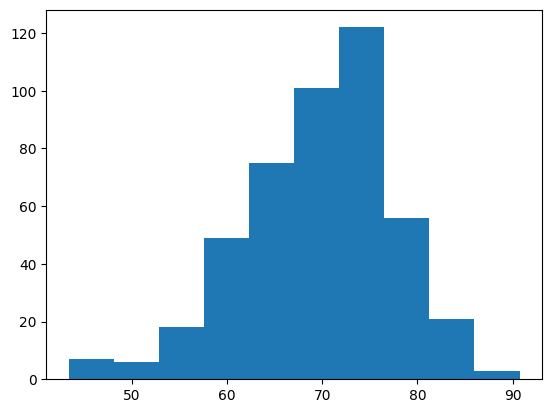

In [ ]:
# Prediction on test set as y_pred.
plt.hist(y_pred_test, label='Data Points')

In [ ]:
from google.colab import files

df_pred = pd.DataFrame({'Predicted_Values': y_pred_test})

df_combined = pd.concat([combined_testing_df, df_pred], axis=1)

#Get output of the predicted values
df_combined.to_excel('output.xlsx', index=False)

**Insights**

* The histogram of the predicted `life_expectancy` is a normal distribution similar to that of the training set.
* The average of the distribution is 72 - 76 range, this makes intuitive sense as the range of values are similar to life expectancy of humans - 72.6 years
https://ourworldindata.org/life-expectancy